In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os

# ==========================================
# CONFIGURATION
# ==========================================
# Ensure this matches your Kaggle input path
INPUT_FILE_PATH = "/kaggle/input/nlp2-cse/Bengali_Banglish_80K_Dataset2.csv" 
OUTPUT_DIR = "/kaggle/working/"

# ==========================================
# 1. LOAD & CLEAN DATA
# ==========================================
print("Loading dataset...")

encodings_to_try = ['utf-8', 'cp1252', 'iso-8859-1', 'utf-16']
df = None
for encoding in encodings_to_try:
    try:
        print(f"Trying encoding: {encoding}...")
        df = pd.read_csv(INPUT_FILE_PATH, encoding=encoding)
        print(f"Success with {encoding}!")
        break
    except UnicodeDecodeError:
        pass
    except Exception as e:
        print(f"Other error with {encoding}: {e}")

if df is None:
    print("All standard encodings failed. Forcing load by ignoring errors...")
    df = pd.read_csv(INPUT_FILE_PATH, encoding='utf-8', encoding_errors='ignore')

# Drop rows with missing values
df = df.dropna(subset=['Bengali', 'Banglish', 'English'])

# Ensure all are strings
df['Bengali'] = df['Bengali'].astype(str).str.strip()
df['Banglish'] = df['Banglish'].astype(str).str.strip()
df['English'] = df['English'].astype(str).str.strip()

print(f"Total clean rows: {len(df)}")

# ==========================================
# 2. PREPARE TRANSLITERATION DATASET (ByT5)
# Input: Banglish, Target: Bengali
# ==========================================
print("Preparing Transliteration (Banglish -> Bengali) data...")

# We use the prefix pattern T5 models expect to understand the task
trans_df = pd.DataFrame()
trans_df['input_text'] = "transliterate: " + df['Banglish']
trans_df['target_text'] = df['Bengali']

# Split Transliteration data (90% Train, 10% Test)
trans_train, trans_test = train_test_split(trans_df, test_size=0.1, random_state=42)

# Save as JSON (preferred for Hugging Face datasets)
trans_train.to_json(os.path.join(OUTPUT_DIR, "trans_train.json"), orient="records", lines=True)
trans_test.to_json(os.path.join(OUTPUT_DIR, "trans_test.json"), orient="records", lines=True)

print(f"Transliteration Train Size: {len(trans_train)}, Test Size: {len(trans_test)}")
print("\n✅ Data Preparation Complete! Files saved.")

Loading dataset...
Trying encoding: utf-8...
Success with utf-8!
Total clean rows: 80094
Preparing Transliteration (Banglish -> Bengali) data...
Transliteration Train Size: 72084, Test Size: 8010

✅ Data Preparation Complete! Files saved.


In [ ]:

!pip install --upgrade --force-reinstall pyarrow -q

!pip install protobuf==3.20.3 transformers datasets evaluate sacrebleu accelerate jiwer -q

print("✅ Libraries fixed! Starting Data Prep...")

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import os
import torch
from transformers import (
    AutoTokenizer, 
    AutoModelForSeq2SeqLM, 
    Seq2SeqTrainingArguments, 
    Seq2SeqTrainer, 
    DataCollatorForSeq2Seq
)
from datasets import load_dataset
import evaluate

# ==========================================
# CONFIGURATION
# ==========================================
# Double check this path matches your Kaggle Input
INPUT_FILE_PATH = "/kaggle/input/nlp2-cse/Bengali_Banglish_80K_Dataset2.csv" 
OUTPUT_DIR = "/kaggle/working/"
MODEL_CHECKPOINT = "google/byt5-small"
MAX_LENGTH = 128

# ==========================================
# 1. DATA PREPARATION
# ==========================================
print("--- STEP 1: LOADING & CLEANING DATA ---")

encodings = ['utf-8', 'cp1252', 'iso-8859-1']
df = None
for encoding in encodings:
    try:
        df = pd.read_csv(INPUT_FILE_PATH, encoding=encoding)
        break
    except:
        continue

if df is None:
    df = pd.read_csv(INPUT_FILE_PATH, encoding='utf-8', encoding_errors='ignore')

# Clean
df = df.dropna(subset=['Bengali', 'Banglish'])
df['Bengali'] = df['Bengali'].astype(str).str.strip()
df['Banglish'] = df['Banglish'].astype(str).str.strip()

# Prepare Transliteration Data
trans_df = pd.DataFrame()
trans_df['input_text'] = "transliterate: " + df['Banglish']
trans_df['target_text'] = df['Bengali']

# Split
train_df, test_df = train_test_split(trans_df, test_size=0.1, random_state=42)

# Save JSONs
train_path = os.path.join(OUTPUT_DIR, "trans_train.json")
test_path = os.path.join(OUTPUT_DIR, "trans_test.json")

train_df.to_json(train_path, orient="records", lines=True)
test_df.to_json(test_path, orient="records", lines=True)

print(f"Data ready: {len(train_df)} training samples created.")


# ==========================================
# 2. TRAINING THE MODEL (FIXED & OPTIMIZED)
# ==========================================
print("\n--- STEP 2: TRAINING MODEL ---")

dataset = load_dataset("json", data_files={"train": train_path, "test": test_path})
tokenizer = AutoTokenizer.from_pretrained(MODEL_CHECKPOINT)
model = AutoModelForSeq2SeqLM.from_pretrained(MODEL_CHECKPOINT)

# --- FIX 1: LABEL PADDING ---
def preprocess_function(examples):
    inputs = examples["input_text"]
    targets = examples["target_text"]
    
    # Tokenize inputs
    model_inputs = tokenizer(inputs, max_length=MAX_LENGTH, truncation=True, padding="max_length")
    
    # Tokenize targets
    labels = tokenizer(targets, max_length=MAX_LENGTH, truncation=True, padding="max_length")
    
    # CRITICAL FIX: Replace pad_token_id (0) with -100 so the model ignores them in loss calculation
    labels["input_ids"] = [
        [(l if l != tokenizer.pad_token_id else -100) for l in label] for label in labels["input_ids"]
    ]
    
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

print("Tokenizing data...")
tokenized_datasets = dataset.map(preprocess_function, batched=True)

# --- METRICS ---
cer_metric = evaluate.load("cer")
bleu_metric = evaluate.load("sacrebleu")

# --- FIX 2: BLEU REFERENCE FORMAT ---
def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple): preds = preds[0]
    
    # Decode Predictions
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    
    # Decode Labels (Replace -100 back to pad token to decode properly)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Clean up text
    decoded_preds = [pred.strip() for pred in decoded_preds]
    decoded_labels = [label.strip() for label in decoded_labels]
    
    # CRITICAL FIX: SacreBLEU expects a list of lists for references [[ref1], [ref2]]
    # We expand the list dimensions here
    decoded_labels_expanded = [[label] for label in decoded_labels]
    
    cer = cer_metric.compute(predictions=decoded_preds, references=decoded_labels)
    # Pass the expanded labels to BLEU
    bleu = bleu_metric.compute(predictions=decoded_preds, references=decoded_labels_expanded)
    
    return {"cer": cer, "bleu": bleu['score']}

# Training Args
args = Seq2SeqTrainingArguments(
    output_dir="banglish_byt5_model",
    eval_strategy="epoch",      
    save_strategy="epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=4,          # ✅ Correctly set to 4
    predict_with_generate=True,
    fp16=True, 
    report_to="none",
    load_best_model_at_end=True,  # Automatically loads the best epoch at the end
    
    # --- CRITICAL FIX FOR BLEU SCORE ---
    generation_max_length=128     # Forces model to generate full sentences (bytes)
    # -----------------------------------
)

trainer = Seq2SeqTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    data_collator=DataCollatorForSeq2Seq(tokenizer, model=model),
    tokenizer=tokenizer,
    compute_metrics=compute_metrics, 
)

print("Starting training...")
trainer.train()

# Save final model
trainer.save_model("final_banglish_model")
tokenizer.save_pretrained("final_banglish_model")
print("✅ Training Complete! Model saved.")

2025-12-16 11:09:24.931845: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765883364.954070   10965 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765883364.960721   10965 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


--- STEP 1: LOADING & CLEANING DATA ---
Data ready: 72084 training samples created.

--- STEP 2: TRAINING MODEL ---


Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Tokenizing data...


Map:   0%|          | 0/72084 [00:00<?, ? examples/s]

Map:   0%|          | 0/8010 [00:00<?, ? examples/s]

/tmp/ipykernel_10965/2869959102.py:147: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Starting training...


Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Cer,Bleu
1,0.039800,0.028950,0.042988,78.121559
2,0.029000,0.024364,0.039361,80.937469
3,0.023600,0.022618,0.039461,82.421549
4,0.021600,0.022037,0.035227,83.322301


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight'].


✅ Training Complete! Model saved.


--- STEP 3: GENERATING GRAPHS ---


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

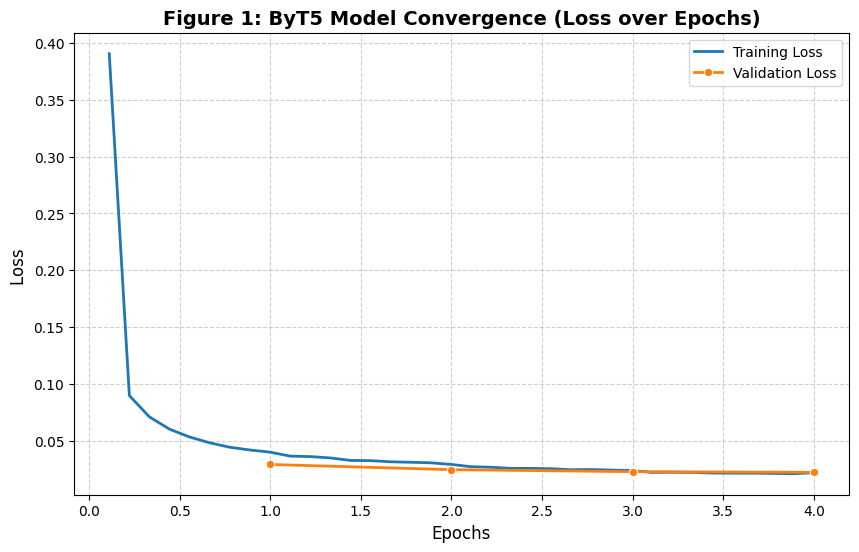

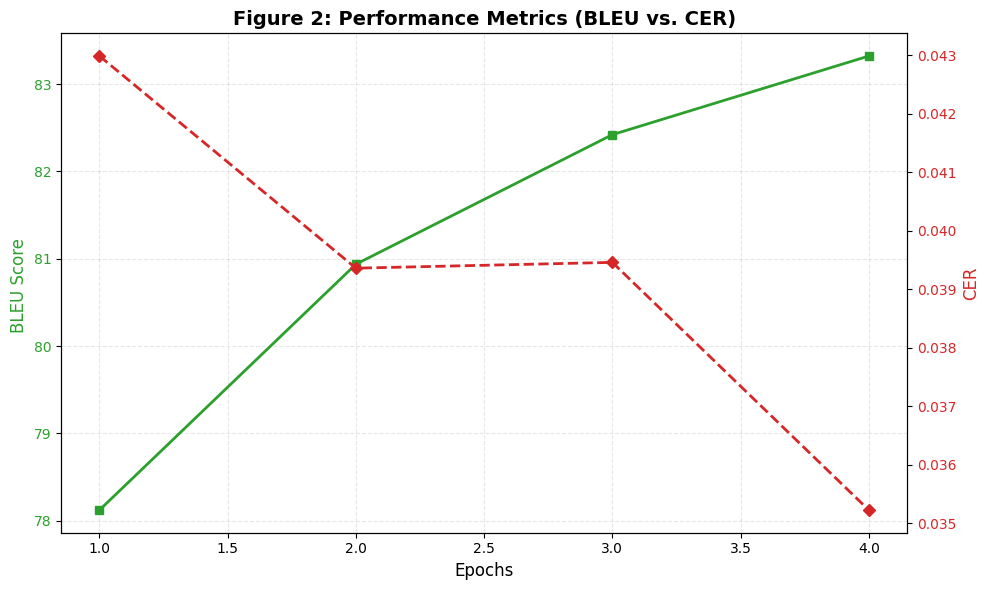


FINAL RESULTS 
Final Validation Loss: 0.0220
Final BLEU Score:      83.32  (Goal: > 60)
Final CER Score:       0.0352   (Goal: < 0.1)
 Graphs saved as 'fig1_loss_curve.png' and 'fig2_metrics.png'


In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ==========================================
# 3. EXTRACT & VISUALIZE RESULTS
# ==========================================
print("--- STEP 3: GENERATING GRAPHS ---")

# 1. Extract Logs from Trainer Memory
# This works because 'trainer' is still in memory from the previous cell
history = trainer.state.log_history
log_df = pd.DataFrame(history)

# 2. Separate Training and Evaluation Logs
# Training logs have 'loss'
train_logs = log_df.dropna(subset=['loss']).reset_index(drop=True)
# Evaluation logs have 'eval_loss', 'eval_bleu', 'eval_cer'
eval_logs = log_df.dropna(subset=['eval_loss']).reset_index(drop=True)

# --- GRAPH A: TRAINING vs VALIDATION LOSS 
plt.figure(figsize=(10, 6))
sns.lineplot(data=train_logs, x='epoch', y='loss', label='Training Loss', color='#1f77b4', linewidth=2)
sns.lineplot(data=eval_logs, x='epoch', y='eval_loss', label='Validation Loss', color='#ff7f0e', linewidth=2, marker='o')

plt.title('Figure 1: ByT5 Model Convergence (Loss over Epochs)', fontsize=14, fontweight='bold')
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss ', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.savefig('fig1_loss_curve.png', dpi=300)
plt.show()

# --- GRAPH B: ACCURACY METRICS (BLEU & CER) 
# Dual-axis plot: BLEU on left (High is good), CER on right (Low is good)
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:green'
ax1.set_xlabel('Epochs', fontsize=12)
ax1.set_ylabel('BLEU Score ', color=color, fontsize=12)
ax1.plot(eval_logs['epoch'], eval_logs['eval_bleu'], color=color, marker='s', linewidth=2, label='BLEU Score')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, linestyle='--', alpha=0.3)

ax2 = ax1.twinx()  # Second Y-axis
color = 'tab:red'
ax2.set_ylabel('CER', color=color, fontsize=12)

ax2.plot(eval_logs['epoch'], eval_logs['eval_cer'], color=color, marker='D', linewidth=2, linestyle='--', label='CER')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Figure 2: Performance Metrics (BLEU vs. CER)', fontsize=14, fontweight='bold')
fig.tight_layout()
plt.savefig('fig2_metrics.png', dpi=300)
plt.show()

# --- PRINT FINAL TABLE FOR YOUR PAPER ---
if not eval_logs.empty:
    # Get the results from the very last epoch
    final_row = eval_logs.iloc[-1]
    
    print("\n" + "="*40)
    print("FINAL RESULTS ")
    print("="*40)
    print(f"Final Validation Loss: {final_row['eval_loss']:.4f}")
    print(f"Final BLEU Score:      {final_row['eval_bleu']:.2f}  (Goal: > 60)")
    print(f"Final CER Score:       {final_row['eval_cer']:.4f}   (Goal: < 0.1)")
    print("="*40)
    print(" Graphs saved as 'fig1_loss_curve.png' and 'fig2_metrics.png'")
else:
    print(" No evaluation logs found.")

In [11]:
import shutil
import os
from IPython.display import FileLink

print("Zipping model files... this may take 2-3 minutes...")

# 1. Zip the model folder
output_filename = "banglish_model_final"
dir_name = "final_banglish_model"
shutil.make_archive(output_filename, 'zip', dir_name)

print(f"✅ Zipped successfull.")


FileLink(f"{output_filename}.zip")

Zipping model files... this may take 2-3 minutes...
✅ Zipped successfull.


/kaggle/working/banglish_model_final.zip

**Live test**

In [12]:
 from transformers import pipeline
import pandas as pd

# 1. Load 
device = 0 if torch.cuda.is_available() else -1
my_model = pipeline("text2text-generation", model="final_banglish_model", tokenizer="final_banglish_model", device=device)

# 2. Define Stress Test Cases
stress_cases = [
    # Category 1: Heavy Code-Mixing (Banglish + English words)
    {"type": "Code-Mixing", "input": "amar exam er result published hoyeche"},
    {"type": "Code-Mixing", "input": "plz amar assignment ta submit kore dio"},
    
    # Category 2: Ambiguous/Complex Spelling
    {"type": "Complex Spelling", "input": "onushthan ta ossadharon chilo"},  # 'ss' 'dh' combinations
    {"type": "Complex Spelling", "input": "biddaloy er porikkha"},            # 'dd' conjuncts
    
    # Category 3: Numbers & Dates
    {"type": "Numbers/Dates", "input": "21 February amader matri vasha dibosh"},
    {"type": "Numbers/Dates", "input": "amar boyosh 25 bochor"},
    
    # Category 4: Noisy/Bad Typing
    {"type": "Noisy Input", "input": "amr mn vlo nei"},  # Missing vowels (Short text)
    {"type": "Noisy Input", "input": "tmk onk vlobshi"}, # Informal short form
]

# 3. Run Predictions
print("Running Stress Test...")
results = []
for case in stress_cases:
    # Add prefix
    text = "transliterate: " + case["input"]
    pred = my_model(text, max_length=128)[0]['generated_text']
    
    results.append({
        "Category": case["type"],
        "Input (Banglish)": case["input"],
        "Model Output (Bengali)": pred
    })

# 4. Show Results
results_df = pd.DataFrame(results)
print(results_df)

# Save for your report
results_df.to_csv("failure_analysis.csv", index=False)
print("\nSaved 'failure_analysis.csv'.")

Device set to use cuda:0
Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Running Stress Test...


Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=128) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


           Category                        Input (Banglish)  \
0       Code-Mixing   amar exam er result published hoyeche   
1       Code-Mixing  plz amar assignment ta submit kore dio   
2  Complex Spelling           onushthan ta ossadharon chilo   
3  Complex Spelling                    biddaloy er porikkha   
4     Numbers/Dates   21 February amader matri vasha dibosh   
5     Numbers/Dates                   amar boyosh 25 bochor   
6       Noisy Input                          amr mn vlo nei   
7       Noisy Input                         tmk onk vlobshi   

                  Model Output (Bengali)  
0   আমার একাম এর রেসুল্ট পুবলিশেড হয়েছে  
1  plz আমার assignment টা সুবমিট করে দিও  
2              অনুষ্ঠান টা অসসাধারণ ছিলো  
3                    বিদ্দালয় এর পরীক্ষা  
4  ২১ ফেব্রুয়ারি আমাদের মাত্রই ভাষা দিবস  
5                        আমার বয়স ২৫ বছর  
6                        আমর মন ভ্লো নেই  
7                        tmk onk vlobshi  

Saved 'failure_analysis.csv'.
